In [2]:
import geopandas as gpd
import pandas as pd
import requests
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString, Point, MultiPoint
from shapely import set_precision
import contextily as ctx
from shapely.ops import unary_union, linemerge, snap
from shapely.validation import make_valid
from math import isfinite
from scipy.spatial import cKDTree
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.lines as mlines
import matplotlib.patches as mpatches


In [3]:
states = gpd.read_file('../raw data/state level data/tl_2024_us_state/tl_2024_us_state.shp').to_crs(5070)
states = states[~states.STATEFP.isin(['02', '14', '15', '72', '07', '03', '43', '52', '78', '72', '69', '66', '60'])]
states['centroid'] = states.geometry.centroid
states.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,GEOIDFQ,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,centroid
0,3,5,54,01779805,54,0400000US54,WV,West Virginia,00,G4000,A,62266513826,488918898,+38.6472854,-080.6183274,"POLYGON ((1548777.304 1961418.875, 1548791.323...",POINT (1320070.121 1841679.16)
1,3,5,12,00294478,12,0400000US12,FL,Florida,00,G4000,A,138965379385,45968913048,+28.3989775,-082.5143005,"MULTIPOLYGON (((1318717.052 267177.248, 131868...",POINT (1322061.162 687777.997)
2,2,3,17,01779784,17,0400000US17,IL,Illinois,00,G4000,A,143778206717,6216848695,+40.1028754,-089.1526108,"POLYGON ((701650.471 1724476.457, 701575.841 1...",POINT (578369.408 1919025.801)
3,2,4,27,00662849,27,0400000US27,MN,Minnesota,00,G4000,A,206244791203,18937236061,+46.3159573,-094.1996043,"POLYGON ((50386.396 2888284.096, 50544.128 288...",POINT (139053.935 2592660.128)
4,3,5,24,01714934,24,0400000US24,MD,Maryland,00,G4000,A,25151223822,6979843236,+38.9466584,-076.6744939,"POLYGON ((1718035.44 1986172.419, 1718118.217 ...",POINT (1647599.237 1936930.189)


In [7]:
W = pd.read_csv('../processed data/state_level/state_level_highway_weights.csv', index_col=0)
W.index = W.columns
W

,54,12,17,27,24,44,16,33,37,50,...,29,30,20,18,46,25,51,11,19,04
54,0.000000,0.015074,0.020167,0.002383,0.047853,0.001125,0.000200,0.000996,0.037412,0.000370,...,0.008578,0.000179,0.001356,0.021190,0.000379,0.007917,0.061668,0.001160,0.001921,0.001151
12,0.015074,0.000000,0.067673,0.012779,0.071626,0.003634,0.001808,0.003908,0.210871,0.001441,...,0.049383,0.001408,0.009108,0.049972,0.002507,0.026985,0.113923,0.001984,0.008939,0.012954
17,0.020167,0.067673,0.000000,0.078009,0.056580,0.003185,0.002830,0.003379,0.066632,0.001292,...,0.625810,0.002957,0.041015,0.919879,0.009808,0.024149,0.079670,0.001457,0.121699,0.016613
27,0.002383,0.012779,0.078009,0.000000,0.008884,0.000666,0.001715,0.000762,0.010706,0.000289,...,0.027146,0.003056,0.009964,0.027796,0.008468,0.005208,0.011672,0.000232,0.063249,0.004801
24,0.047853,0.071626,0.056580,0.008884,0.000000,0.013395,0.000825,0.009730,0.311276,0.003638,...,0.026728,0.000742,0.004719,0.050453,0.001424,0.088935,0.810248,0.383142,0.006327,0.004646
44,0.001125,0.003634,0.003185,0.000666,0.013395,0.000000,0.000073,0.010134,0.006522,0.001936,...,0.001669,0.000064,0.000330,0.002438,0.000112,0.637187,0.008876,0.000306,0.000451,0.000385
16,0.000200,0.001808,0.002830,0.001715,0.000825,0.000073,0.000000,0.000090,0.001131,0.000033,...,0.002053,0.002168,0.001189,0.001277,0.000530,0.000575,0.001142,0.000022,0.000813,0.002949
33,0.000996,0.003908,0.003379,0.000762,0.009730,0.010134,0.000090,0.000000,0.006021,0.007801,...,0.001825,0.000076,0.000373,0.002483,0.000131,0.153737,0.007626,0.000232,0.000508,0.000462
37,0.037412,0.210871,0.066632,0.010706,0.311276,0.006522,0.001131,0.006021,0.000000,0.002233,...,0.032937,0.000966,0.006055,0.055019,0.001818,0.046459,0.661770,0.009133,0.007894,0.007397
50,0.000370,0.001441,0.001292,0.000289,0.003638,0.001936,0.000033,0.007801,0.002233,0.000000,...,0.000694,0.000029,0.000141,0.000956,0.000049,0.023930,0.002835,0.000087,0.000193,0.000173


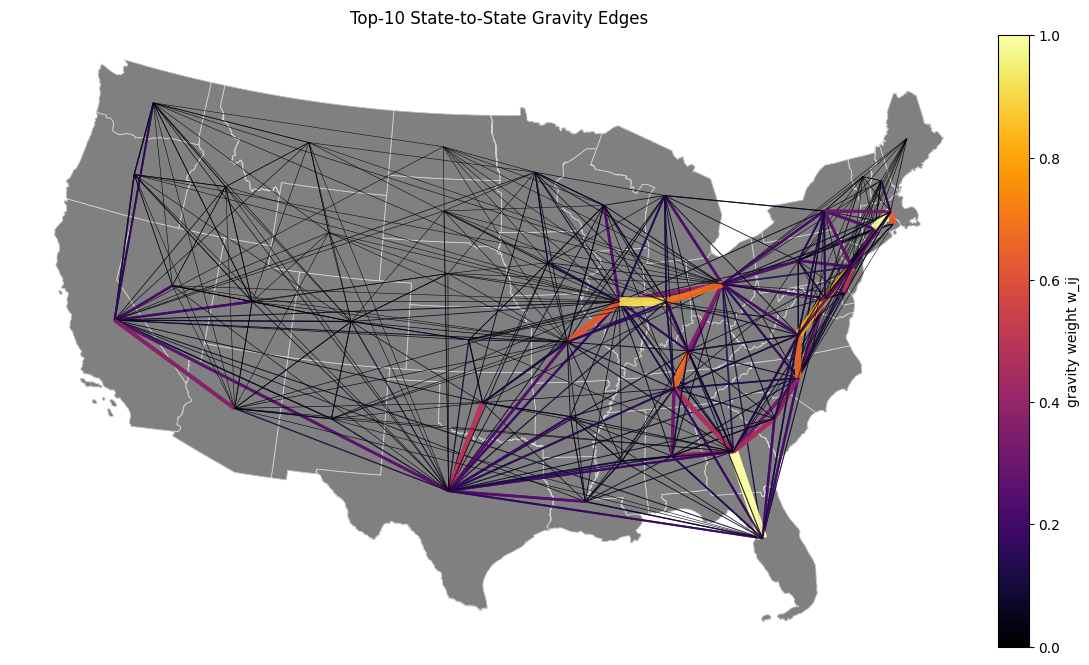

In [8]:
W_np = W.to_numpy()
STATE_ID_COL = "STATEFP"
anchors = states.copy()

# 1) Build an edges table (top-K per state to reduce clutter)
K = 10
rows = []
ids = anchors[STATE_ID_COL].tolist()
pts = list(anchors.centroid)

for i in range(len(ids)):
    # get top-K j (exclude self, nonpositive)
    wrow = W_np[i, :].copy()
    js = np.argsort(wrow)[::-1][:K]
    for j in js:
        if wrow[j] <= 0: 
            continue
        rows.append({
            "i": ids[i], "j": ids[j],
            "w": float(wrow[j]),
            "geometry": LineString([(pts[i].x, pts[i].y), (pts[j].x, pts[j].y)])
        })

edges_df = gpd.GeoDataFrame(rows, geometry="geometry", crs=states.crs)

# 2) Map weights to color/linewidth
vals = edges_df["w"].to_numpy()
colors = plt.cm.inferno(vals)
lw = 0.4 + 3.0 * (vals - np.percentile(vals, 5)) / (np.percentile(vals, 95) - np.percentile(vals, 5))

# 3) Plot
fig, ax = plt.subplots(figsize=(11, 8))
states.boundary.plot(ax=ax, linewidth=0.6, color="lightgray", facecolor='gray')
edges_df.plot(ax=ax, color=colors, linewidth=lw, alpha=0.9)
anchors.plot(ax=ax, markersize=25, color="black")

sm = ScalarMappable(cmap="inferno")
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.01)
cbar.set_label("gravity weight w_ij")

ax.set_axis_off()
ax.set_title(f"Top-{K} State-to-State Gravity Edges")
plt.tight_layout()
plt.show()
